In [13]:
import pandas as pd
pd.set_option('display.precision', 2)
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from IPython.core.display import display
from collections import defaultdict
import itertools
import warnings
warnings.filterwarnings('ignore')

## 1. S&P 500 Index Data

(10846, 10)


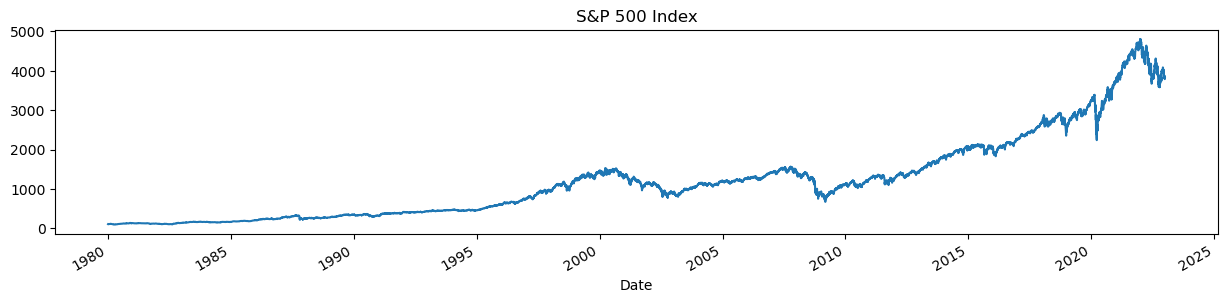

In [14]:
# download data (multiple times due to 5000 rows limit) from 
# https://cn.investing.com/indices/us-spx-500-historical-data
df1 = pd.read_csv("sp500_history_1.csv")
df2 = pd.read_csv("sp500_history_2.csv")
df3 = pd.read_csv("sp500_history_3.csv")
df = pd.concat([df1, df2, df3])
del df1, df2, df3

df.rename(columns={"日期":"Date", "收盘":"Close", "开盘":"Open", "高":"High", "低":"Low", "交易量":"Volume", "涨跌幅":"Change"}, inplace=True)
df.index = pd.to_datetime(df["Date"])
df.sort_index(inplace=True)
df = df.iloc[4:(-54), :] # start clean on 1980-01-01 to 2022-12-30
assert df.index.nunique() == df.shape[0]
df["Close"] = df.Close.str.replace(",","").astype(float)
df["Open"] = df.Open.str.replace(",","").astype(float)
df["High"] = df.High.str.replace(",","").astype(float)
df["Low"] = df.Low.str.replace(",","").astype(float)
df["Change"] = df.Change.str.replace("%","").astype(float)
df["DayOfWeek"] = df.index.weekday
df["DayOfMonth"] = df.index.day
df["YearMonth"] = [str(x)[:7] for x in df.index]

print(df.shape)
_ = df.Close.plot(figsize=(15,3), title="S&P 500 Index")

In [15]:
df.head()

,Date,Close,Open,High,Low,Volume,Change,DayOfWeek,DayOfMonth,YearMonth
Date,,,,,,,,,,
1980-01-01,1980-1-1,107.9,107.9,107.9,107.9,NaN,0.00,1,1,1980-01
1980-01-02,1980-1-2,105.8,105.8,108.4,105.3,NaN,-1.95,2,2,1980-01
1980-01-03,1980-1-3,105.2,105.2,106.1,103.3,NaN,-0.57,3,3,1980-01
1980-01-04,1980-1-4,106.5,106.5,107.1,105.1,NaN,1.24,4,4,1980-01
1980-01-07,1980-1-7,106.8,106.8,107.8,105.8,NaN,0.28,0,7,1980-01


## 2. Inflation data to get market value of $100 since 1980

In [3]:
# download at https://www.in2013dollars.com/us/inflation/1980
inflation = pd.read_csv("inflation1980.csv")
print(inflation.shape)
display(inflation.head())
display(inflation.tail())

(44, 3)


,Year,Dollar Value,Inflation Rate
0,1980,$100.00,13.50%
1,1981,$110.32,10.32%
2,1982,$117.11,6.16%
3,1983,$120.87,3.21%
4,1984,$126.09,4.32%


,Year,Dollar Value,Inflation Rate
39,2019,$310.26,1.76%
40,2020,$314.09,1.23%
41,2021,$328.85,4.70%
42,2022,$355.16,8.00%
43,2023,$365.10,2.80%


## 3. Merge and process two data sources

In [4]:
simulation = df.copy()
simulation["year"] = simulation.index.year
simulation = pd.merge(left=simulation, right=inflation, left_on="year", right_on="Year", how="left")
simulation.index = pd.to_datetime(simulation["Date"])
simulation["Dollar Value"] = simulation["Dollar Value"].str.replace("$","").astype(float)
simulation.drop(columns=["Date", "Volume", "High", "Low", "year", "Year", "Inflation Rate"], inplace=True)
print(simulation.shape)
simulation.tail() # $100 dollar in 1980 is $355 dollar in 2022!

(10846, 7)


,Close,Open,Change,DayOfWeek,DayOfMonth,YearMonth,Dollar Value
Date,,,,,,,
2022-12-23,3844.82,3815.11,0.59,4,23,2022-12,355.16
2022-12-27,3829.25,3843.34,-0.40,1,27,2022-12,355.16
2022-12-28,3783.22,3829.56,-1.20,2,28,2022-12,355.16
2022-12-29,3849.28,3805.45,1.75,3,29,2022-12,355.16
2022-12-30,3839.50,3829.06,-0.25,4,30,2022-12,355.16


In [5]:
simulation.head()

,Close,Open,Change,DayOfWeek,DayOfMonth,YearMonth,Dollar Value
Date,,,,,,,
1980-01-01,107.9,107.9,0.00,1,1,1980-01,100.0
1980-01-02,105.8,105.8,-1.95,2,2,1980-01,100.0
1980-01-03,105.2,105.2,-0.57,3,3,1980-01,100.0
1980-01-04,106.5,106.5,1.24,4,4,1980-01,100.0
1980-01-07,106.8,106.8,0.28,0,7,1980-01,100.0


## 4. Backtest for simple buy strategy

### 4.1 buy on a specific day of month, which day is best?

,buying_on_Nth_day_of_a_month,total_spend,total_portfolio,return
1,1,111780.72,655691.04,586.59%
7,7,111780.72,655494.97,586.41%
6,6,111780.72,655242.34,586.19%


,buying_on_Nth_day_of_a_month,total_spend,total_portfolio,return
27,27,111780.72,652870.31,584.06%
26,26,111780.72,652666.91,583.88%
28,28,111780.72,652630.19,583.85%


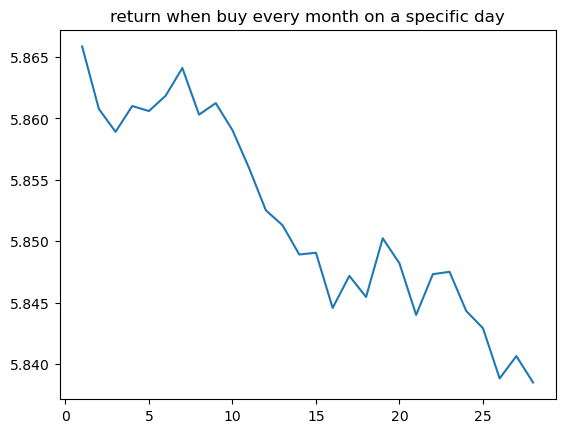

In [6]:
result = defaultdict(dict)
for i in range(1,29):
    execute_dayOfMonth = i
    execute_time = "Close"

    backtest = []
    for name, group in simulation.groupby("YearMonth"):
        try:
            # if execute day is weekend, take the first business day after
            backtest.append(group.loc[group.DayOfMonth>=execute_dayOfMonth,:].iloc[[0],:]) 
        except:
            # if that doesn't work, take the business day before
            backtest.append(group.loc[group.DayOfMonth<=execute_dayOfMonth,:].iloc[[-1],:]) 
    backtest = pd.concat(backtest)
    backtest.loc[:, "Shares"] = backtest["Dollar Value"] / backtest[execute_time]
    total_spend = backtest["Dollar Value"].sum()
    total_portfolio = backtest.Shares.sum() * df["Close"].values[-1]
    result[i]["total_spend"] = total_spend
    result[i]["total_portfolio"] = total_portfolio
    result[i]["return"] = total_portfolio / total_spend
        
result = pd.DataFrame.from_dict(result, orient="index")
result["return"].plot(title="return when buy every month on a specific day")
result["return"] = round(result["return"]*100,2).astype(str)+"%"
result["buying_on_Nth_day_of_a_month"] = result.index
result = result[["buying_on_Nth_day_of_a_month", "total_spend", "total_portfolio", "return"]]
display(result.sort_values("return", ascending=False).head(3))
display(result.sort_values("return", ascending=False).tail(3))

### 4.2 buy on a specific day of a specific week , which day is best?

,buy on every xxx,total_spend,total_portfolio,return
13.0,1st week Thursday,111780.72,695448.04,622.15%
14.0,1st week Friday,111780.72,695019.67,621.77%
21.0,2nd week Tuesday,111780.72,685222.70,613.01%


,buy on every xxx,total_spend,total_portfolio,return
31.0,3rd week Tuesday,111780.72,650371.83,581.83%
43.0,4th week Thursday,111780.72,649362.96,580.93%
42.0,4th week Third,111780.72,642884.72,575.13%


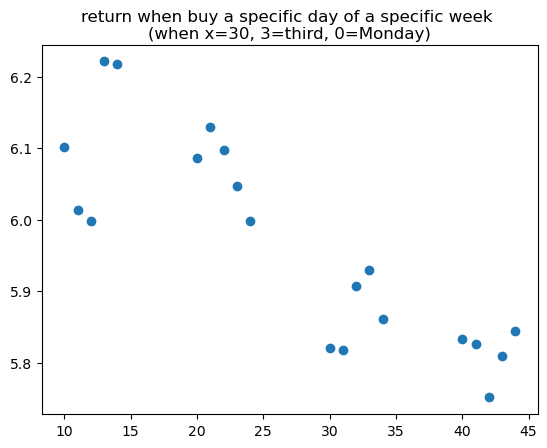

In [7]:
# denote (3,0) to be the third Monday, (1,4) to be the first Friday
result = defaultdict(dict)
for (week, day) in itertools.product([1,2,3,4], [0,1,2,3,4]):
    backtest = []
    for name, group in simulation.groupby("YearMonth"):
        # 2001/9/11 is a special week, use the week after
        if name == "2001-09" and week == 2 and day in [1,2,3,4]:
            backtest.append(group.loc[group.DayOfWeek == day,:].iloc[[week], :])
            continue
        try:
            backtest.append(group.loc[group.DayOfWeek == day,:].iloc[[week-1], :])
        except:
            try:
                # when it's holiday (usually Monday), let's use the Tuesday instead
                backtest.append(group.loc[group.DayOfWeek == (day+1),:].iloc[[week-1], :])
            except:
                # run out of month, use the last day
                backtest.append(group.iloc[[-1],:])
    backtest = pd.concat(backtest)
    backtest.loc[:, "Shares"] = backtest["Dollar Value"] / backtest[execute_time]
    total_spend = backtest["Dollar Value"].sum()
    total_portfolio = backtest.Shares.sum() * backtest["Close"].values[-1]
    k = float(str(week)+str(day))
    result[k]["total_spend"] = total_spend
    result[k]["total_portfolio"] = total_portfolio
    result[k]["return"] = total_portfolio / total_spend

result = pd.DataFrame.from_dict(result, orient="index")
plt.scatter(x=result.index, y=result["return"])
_ = plt.title("return when buy a specific day of a specific week \n" + \
              "(when x=30, 3=third, 0=Monday)", wrap=True)
result["return"] = round(result["return"]*100,2).astype(str)+"%"
def readable_text(k):
    k=str(k)
    w = {"1":"1st", "2":"2nd", "3":"3rd", "4":"4th"}
    d = {"0":"Monday", "1":"Tuesday", "2":"Third", "3":"Thursday", "4":"Friday"}
    return f"{w[k[0]]} week {d[k[1]]}"
result["buy on every xxx"] = [readable_text(k) for k in result.index]
result = result[["buy on every xxx", "total_spend", "total_portfolio", "return"]]
display(result.sort_values("return", ascending=False).head(3))
display(result.sort_values("return", ascending=False).tail(3))

## 5. Backtest for moving-average buy strategy

### 5.1 understand the frequency on MA crossover price

In [8]:
def ma_sim(ma, simulation):
    simulation["ma"] = simulation.Close.rolling(window=ma).mean()
    simulation["price_cross_over_ma"] = simulation.Close >= simulation.ma
    simulation["first_crossover"] = False
    
    below_ma_stage = True
    for i in range(simulation.shape[0]):
        if below_ma_stage==True and simulation.price_cross_over_ma[i]==True:
            simulation.first_crossover[i]=True
            below_ma_stage=False
        elif below_ma_stage==False and simulation.price_cross_over_ma[i]==False:
            simulation.first_crossover[i]=False
            below_ma_stage=True 
        else:
            simulation.first_crossover[i]=False
    
            
    return simulation["first_crossover"].sum(), simulation["first_crossover"].sum() \
            / simulation.YearMonth.nunique()

result = defaultdict(dict)
for ma in [5, 10, 30, 60, 90]:
    occurrence_count, avg_freq_per_month = ma_sim(ma, simulation)
    result[ma]["occurrence_count"] = occurrence_count
    result[ma]["avg_freq_per_month"] = avg_freq_per_month
    
result = pd.DataFrame.from_dict(result, orient="index")
display(result.head())

,occurrence_count,avg_freq_per_month
5,1392,2.70
10,941,1.82
30,507,0.98
60,341,0.66
90,270,0.52


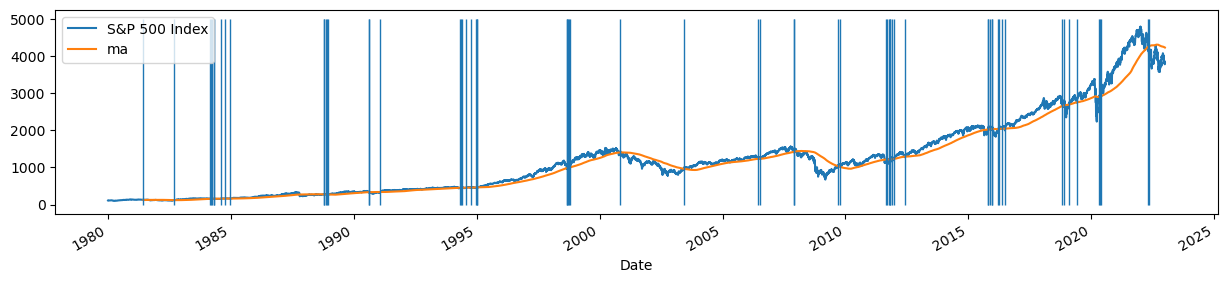

In [9]:
# high level understanding using MA365 as an example
# basically, instead of just buying, only buy a month-worth of budget when price cross down MA30
# because price cross down MA30 happens on average 0.98 times a month, we should have enough budget

occurrence_count, avg_freq_per_month = ma_sim(365, simulation)

_ = simulation.Close.plot(figsize=(15,3), label="S&P 500 Index")
_ = simulation.ma.plot(figsize=(15,3), label="ma")
plt.vlines(simulation.index[simulation.first_crossover==True], ymin=0, ymax=5000, lw=1)
plt.legend()

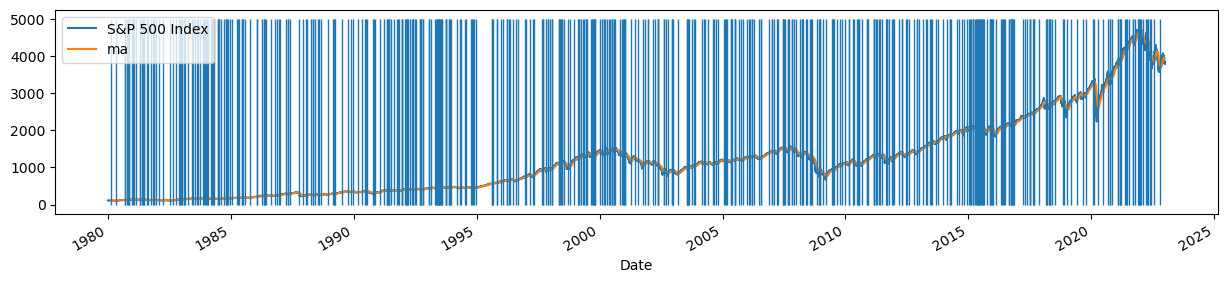

In [10]:
occurrence_count, avg_freq_per_month = ma_sim(30, simulation)

_ = simulation.Close.plot(figsize=(15,3), label="S&P 500 Index")
_ = simulation.ma.plot(figsize=(15,3), label="ma")
plt.vlines(simulation.index[simulation.first_crossover==True], ymin=0, ymax=5000, lw=1)
plt.legend()

### 5.2 backtest the "price cross below MA30" strategy

In [11]:
occurrence_count, avg_freq_per_month = ma_sim(30, simulation)
print(simulation.first_crossover.sum())
print(simulation.YearMonth.nunique())

507
516


In [12]:
result = defaultdict(dict)

simulation.loc[:, "Shares"] = 0
flag = simulation.first_crossover==True
simulation.loc[flag, "Shares"] = simulation.loc[flag, "Dollar Value"] / simulation.loc[flag, "Close"]
result["MA30 Strategy"]["total_spend"] = simulation.loc[flag, "Dollar Value"].sum()
result["MA30 Strategy"]["total_portfolio"] = simulation.Shares.sum() * simulation["Close"].values[-1]
result["MA30 Strategy"]["return"] = result["MA30 Strategy"]["total_portfolio"] / result["MA30 Strategy"]["total_spend"]

result = pd.DataFrame.from_dict(result, orient="index")
result["return"] = round(result["return"]*100,2).astype(str)+"%"
display(result.head())

,total_spend,total_portfolio,return
MA30 Strategy,109973.55,632163.13,574.83%
